# Introduction

This prototype is for UWAIntelliCrop Project. 

1. **Purpose and Application**:
   - Designed to handle multi-spectral imaging data for precise spatial analysis.
   - Designed to classify crops, weeds, as well as others .

2. **Core Technology**:
   - Utilizes TensorFlow and Keras for building and managing deep learning models.
   - Leverages the InceptionV3 architecture, renowned for its effectiveness in image classification tasks.

3. **Custom ResizeLayer**:
   - Introduces a `ResizeLayer` to adjust tensor spatial dimensions dynamically.
   - Ensures compatibility of network layers by matching their input and output sizes, facilitating smooth data processing.

4. **Adaptation of InceptionV3**:
   - Employs InceptionV3 without its classification top layer to extend its application to segmentation tasks.
   - Adapts the model to handle inputs with 15 channels by first reducing them to 3 channels using a custom convolutional layer, making it compatible with the pre-trained model.

5. **Enhancements with Convolutional Layers**:
   - Additional convolutional layers are used to refine features and maintain spatial dimensions.
   - Ends with a convolutional layer that outputs four channels representing different segmentation classes.

6. **Output Processing**:
   - Applies a custom `ResizeLayer` to scale the output back to the original input dimensions (512x512), aligning the output with practical usage requirements.
   - Uses a Softmax layer to convert the final layer outputs into a probability distribution, facilitating easy interpretation of results.

7. **Model Training and Compilation**:
   - Freezes the pre-trained layers to retain learned features while training only the newly added layers.
   - Compiles the model with RMSprop optimizer and categorical cross-entropy loss for effective learning.


# 0. Load Dependencies


This code block imports necessary libraries and defines utility functions for loading and handling data:

In [35]:
import os
import numpy as np
import pandas as pd
import rasterio
import tensorflow as tf
import sys
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Conv2D, UpSampling2D, concatenate, Input, BatchNormalization, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import rasterio
import re


Here libraries are imported for file operations, data manipulation, machine learning, and image processing. The tensorflow library is notably used for building and training deep learning models.

# 1. Data Sourcing: Load from Files



This script defines a **read_X** function that navigates directories to load `multi-spectral` images and their labels for use in deep learning. Each image and its corresponding label are collected unless the directory contains images with `NaN` values, which are skipped.

In [36]:

base_path = './test1'
pattern = re.compile(r'smalldata_(\d+)_(\d+)')
indices = ['ExG', 'ExR', 'PRI', 'MGRVI', 'SAVI', 'MSAVI', 'EVI', 'REIP', 'NDVI', 'GNDVI', 'CI', 'OSAVI', 'TVI', 'MCARI', 'TCARI']

def load_tif(file_path):
    # Function to load .tif file and return as a numpy array using rasterio
    with rasterio.open(file_path) as src:
        return src.read(1)  # Read the first band

def read_X(dir=base_path, indices=indices):
    images = []
    labels = []
    for root, dirs, files in os.walk(dir):
        for dir_name in dirs:
            match = pattern.match(dir_name)
            if match:
                group_number = match.group(1)
                sub_group_number = match.group(2)
                dir_path = os.path.join(root, dir_name)
                channels = []
                skip_directory = False
                for file_name in os.listdir(dir_path):
                    if file_name.endswith('.tif'):
                        for index in indices:
                            if file_name.startswith(index):
                                file_path = os.path.join(dir_path, file_name)
                                data = load_tif(file_path)
                                if np.isnan(data).any():
                                    print(f"Skipping directory due to NaN values in: {file_path}")
                                    skip_directory = True
                                    break
                                channels.append(data)
                        if skip_directory:
                            break
                    if file_name.startswith("label_matrix"):
                        file_path = os.path.join(dir_path, file_name)
                        label_matrix = pd.read_csv(file_path, header=None).values
                if not skip_directory:
                    images.append(channels)
                    labels.append(label_matrix)
    return np.array(images), np.array(labels)

# # Example usage
# images, labels = read_X()
# print(images.shape, labels.shape)


In [37]:
X,y=read_X()

# 2. Helper Functions

This function converts label matrices into one-hot encoded format for neural network classification, where 4 represents the number of classes.

In [38]:
import numpy as np

def convert_to_one_hot(y):
    # Get the shape of the input array
    n, h, w = y.shape
    
    # Initialize an all-zero array with shape (n, h, w, 4)
    y_one_hot = np.zeros((n, h, w, 4), dtype=int)
    
    # Use advanced indexing to convert the original array values to one-hot encoding
    for i in range(4):
        y_one_hot[..., i] = (y == i)
    
    return y_one_hot


def get_predicted_labels(predictions):
    """
    Convert the predicted probability array to a label array.
    
    Parameters:
    predictions: A predicted probability array with shape (n, 512, 512, 4)
    
    Returns:
    A label array with shape (n, 512, 512), where each point represents its most probable class
    """
    predicted_labels = np.argmax(predictions, axis=-1)
    return predicted_labels


def one_hot_to_labels(y_one_hot):
    """
    Convert a one-hot encoded array back to a label array.
    
    Parameters:
    y_one_hot: A one-hot encoded array with shape (n, 512, 512, 4)
    
    Returns:
    A label array with shape (n, 512, 512)
    """
    # Use np.argmax to find the index of the maximum value in the fourth dimension
    y_labels = np.argmax(y_one_hot, axis=-1)
    
    return y_labels


# 3. Model Definition & Model Training

## Preprocess

These lines prepare the data for input into a neural network. They normalize image data, adjust dimension ordering for TensorFlow, and convert labels to one-hot encoding.

In [39]:
# Normalize input data to [0, 1]
X = X / np.max(X)

# Transpose the dimensions of X to (0, 2, 3, 1)
X = X.transpose((0, 2, 3, 1))

# Convert y to one-hot encoding
y_one_hot = convert_to_one_hot(y)


Function `preprocess_image` is designed to preprocess images and labels. In this case, the function simply returns the input images and labels without any modification or resizing. 

Function `load_dataset`constructs a TensorFlow dataset from given image and label arrays.The steps within the function include:

1. Creating a Dataset Object: `tf.data.Dataset.from_tensor_slices((images, labels))` creates a dataset that slices the input arrays along the first dimension. This is useful when each item in the array corresponds to a data point (e.g., an image and its label).

2. Mapping the Preprocessing Function: `dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)` applies the `preprocess_image` function to each element of the dataset. The `num_parallel_calls` parameter set to AUTOTUNE allows TensorFlow to dynamically determine the optimal number of parallel calls to make, which can improve performance by effectively utilizing available CPU resources.

3. Batching and Prefetching: `dataset.batch(batch_size)` groups the dataset elements into batches. This makes it easier to process and train on large datasets because processing small batches typically fits better in memory.
`dataset.prefetch(tf.data.experimental.AUTOTUNE)` prefetches dataset elements in the background while the model is being trained. This helps ensure that the GPU or other processing units do not have to wait for new data to become available, thereby improving training efficiency.

In [40]:
import tensorflow as tf

def preprocess_image(image, label):
    # Do not resize, keep the original dimensions
    return image, label

def load_dataset(images, labels, batch_size=4):
    # Create a TensorFlow dataset from the images and labels
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    
    # Apply the preprocess_image function to each element in the dataset
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # Batch the dataset and prefetch for better performance
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

# Load the training dataset
train_dataset = load_dataset(X, y_one_hot)



## Create CNN using TensorFlow and Keras

Creation of a convolutional neural network (CNN) using TensorFlow and Keras, with a custom layer for resizing, integration of a pre-trained model (InceptionV3), and various adjustments to fit the specific needs of processing multi-channel satellite imagery.

(None, 512, 512, 3)
(None, 14, 14, 512)
(None, 14, 14, 512)
(None, 14, 14, 4)
(None, 512, 512, 4)


In [42]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3

# Define a custom ResizeLayer
class ResizeLayer(tf.keras.layers.Layer):
    def __init__(self, target_height, target_width):
        super(ResizeLayer, self).__init__()
        self.target_height = target_height
        self.target_width = target_width

    def call(self, inputs):
        return tf.image.resize(inputs, (self.target_height, self.target_width))

# Define the input tensor with shape (512, 512, 15)
input_tensor = Input(shape=(512, 512, 15))

# Add a convolutional layer to convert the input to a 3-channel input suitable for InceptionV3
x = Conv2D(3, (1, 1), padding='same', activation='relu')(input_tensor)

# Create the base model with InceptionV3, excluding the top classification layer
# Note: input_shape here is set to (512, 512, 3) since we are modifying it
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# Ensure that base_model is called with a properly formed input
base_model_output = base_model(x)

# Inception Module A (Capture Features at Multiple Scales)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(base_model_output)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

# Reduction Module 1 (Downsample Spatial Dimensions / Lower the complexity)
x = Conv2D(512, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Inception Module B (Reduce Parameters again while Maintaining Performance)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

# Reduction Module 2 (Downsample Spatial Dimensions / Lower the complexity)
x = Conv2D(256, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Inception Module C (Refining Features)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# Use the custom resize layer to resize the output to (512, 512)
x = ResizeLayer(512, 512)(x)

# Add the final convolutional layer
x = Conv2D(4, (1, 1), padding='same')(x)

# Apply the Softmax activation function to ensure the output represents a probability distribution
predictions = tf.keras.layers.Softmax(axis=-1)(x)

# Define the model with the input tensor and the predictions
model = Model(inputs=input_tensor, outputs=predictions)

# Freeze the convolutional layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with RMSprop optimizer and categorical cross-entropy loss
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])




## Train the model
Model Training: The model is trained using the model.fit() method on train_dataset for a total of 10 epochs. The callbacks parameter, which would include a custom callback to monitor the training process, is currently commented out (# callbacks=[callbacks]). 

**What the Callback Accomplishes**
The primary purpose of this callback is to implement early stopping in a custom way. Instead of using the built-in EarlyStopping callback provided by Keras, which stops training when a monitored metric has stopped improving, your custom callback uses a specific threshold for loss values to determine when to stop training. This can be particularly useful if you know from domain knowledge or previous experimentation that a certain loss value corresponds to an adequately trained model.

In [43]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_loss') <= 0.1099 and logs.get('loss') <= 0.1099:
            print('\n\n Reached The Destination!')
            self.model.stop_training = True

callbacks = myCallback()
history = model.fit(
    train_dataset,
    epochs=10
    # callbacks=[callbacks]
)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.0577 - loss: 1.7735
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step - accuracy: 0.8695 - loss: 1.3603
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step - accuracy: 0.8695 - loss: 0.8660
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step - accuracy: 0.8695 - loss: 0.4720
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step - accuracy: 0.8695 - loss: 0.4290
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step - accuracy: 0.8695 - loss: 0.4500
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step - accuracy: 0.8681 - loss: 0.4426
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step - accuracy: 0.8695 - loss: 0.4185
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step - accuracy: 0.8695 - loss: 0.4042
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step - accuracy: 0.8695 - loss: 0.3988


## Save the Model as .h5

In [44]:
model_path='./inceptionv3_fcn_model_23_5.h5'

model.save(model_path)
print(model_path)

./inceptionv3_fcn_model_23_5.h5


In [45]:

if os.path.exists(model_path):
    print(f"Model saved successfully at {model_path}")
else:
    print(f"Model not found at {model_path}")

Model saved successfully at ./inceptionv3_fcn_model_23_5.h5


# 4. Model Testing: Make predictions

## Load Model

### Custom Layer Definition

- **ResizeLayer**: A custom TensorFlow layer that resizes input tensors to specified dimensions, useful for matching tensor sizes in model architectures.

### Custom Objects Dictionary

- A dictionary that maps the string 'ResizeLayer' to the ResizeLayer class, enabling Keras to recognize and use the custom layer during model loading.

### Loading the Model

- The model is loaded with custom layers using `tf.keras.utils.custom_object_scope`, which is necessary when the model includes custom-defined components. The `load_model` function is used with `compile=False` to load the model without compiling it, suitable for inference or later customization.

In [46]:
from keras.models import load_model
import tensorflow as tf

# Define custom layer without 'trainable' argument
class ResizeLayer(tf.keras.layers.Layer):
    def __init__(self, target_height, target_width, **kwargs):
        super(ResizeLayer, self).__init__(**kwargs)
        self.target_height = target_height
        self.target_width = target_width

    def call(self, inputs):
        return tf.image.resize(inputs, [self.target_height, self.target_width])

# Add custom layer to the custom_objects dictionary
custom_objects = {'ResizeLayer': ResizeLayer}

# Load the model with the custom objects
with tf.keras.utils.custom_object_scope(custom_objects):
    model = load_model('inceptionv3_fcn_model_23_5.h5', compile=False)


### `make_pred` Function

- **Purpose**: Generates predictions from test data located in a specified directory.
- **Process**:
  1. **Data Loading**: Utilizes the `read_X` function to load test data (both features and labels) from the provided directory.
  2. **Data Normalization**: Normalizes the feature data to a [0, 1] range for consistency with model training conditions.
  3. **Data Reshaping**: Rearranges the data dimensions to match the input requirements of the TensorFlow model.
  4. **Prediction**: Employs the previously trained model to compute predictions on the processed test data.
  5. **One-Hot Encoding**: Converts the test labels into one-hot encoded format to facilitate comparison and evaluation against model predictions.
- **Returns**: A tuple containing one-hot encoded test labels and the model predictions for evaluation.

In [47]:
def make_pred(dir):
    # Read the test data from the specified directory
    X_test, y_test = read_X(dir=dir)
    
    # Print the shape and data type of the test data
    print(f"Shape of X_test: {X_test.shape}")
    print(f"Data type of X_test: {X_test.dtype}")
    
    # Normalize the test data to the range [0, 1]
    X_test = X_test / np.max(X_test)
    
    # Transpose the dimensions of X_test to (0, 2, 3, 1)
    X_test = X_test.transpose((0, 2, 3, 1))
    
    # Make predictions using the model
    predictions = model.predict(X_test)
    
    # Uncomment the following line to print the predictions
    # print(predictions)
    
    # Convert y_test to one-hot encoding
    y_test_one_hot = convert_to_one_hot(y_test)
    
    return y_test_one_hot, predictions


## Make predictions

In [48]:
y_test,y_pred= make_pred(dir='./testset')


Shape of X_test: (4, 15, 512, 512)
Data type of X_test: float32
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


# 5. Model Evaluation

## Verification of Prediction Normalization

- **Purpose**: Validates that the sum of probabilities across all channels for each pixel in the predictions equals 1, ensuring that the output from the model represents a valid probability distribution.
- **Process**:
  1. **Sum Calculation**: Computes the sum of predicted values across all channels for each pixel using `np.sum(y_pred, axis=-1)`.
  2. **Verification**: Uses `np.allclose(sum_of_channels, 1)` to check if all these sums are close to 1, confirming proper softmax normalization in the model's output.
- **Output**: Prints a boolean result indicating whether all pixel predictions adhere to the expected normalization criterion. This step is crucial for confirming that the model's predictions are probabilistically sound.

In [49]:
# Check if the sum of channel values for each pixel is equal to 1
sum_of_channels = np.sum(y_pred, axis=-1)
#print(sum_of_channels)

# Verify if all values are close to 1
are_all_close_to_one = np.allclose(sum_of_channels, 1)
print(f"Are all sums of the four channels equal to 1? {are_all_close_to_one}")


Are all sums of the four channels equal to 1? True


## Calculate Accuracy

In [50]:
def calculate_accuracy(y_true, y_pred, num_classes=4):
    """
    Calculate classification accuracy.
    
    :param y_true: Actual labels, shape (batch_size, height, width, num_classes)
    :param y_pred: Predicted labels, shape (batch_size, height, width, num_classes)
    :param num_classes: Number of classes
    :return: Classification accuracy
    """
    # Convert one-hot encoded labels to class indices
    y_true_class = np.argmax(y_true, axis=-1)
    y_pred_class = np.argmax(y_pred, axis=-1)
    
    # Calculate accuracy
    correct_predictions = np.sum(y_true_class == y_pred_class)
    total_predictions = y_true_class.size
    
    accuracy = correct_predictions / total_predictions
    return accuracy

# Call the function to calculate accuracy
calculate_accuracy(y_test, y_pred, num_classes=4)


0.8716917037963867

## Calculate MIoU

mIoU (Mean Intersection over Union) is calculated as the average of the ratio of the intersection to the union of the predicted and actual segmentations across classes,it providing a measure of a segmentation model's accuracy and consistency.
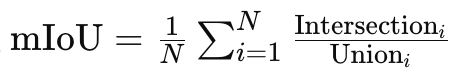

In [51]:
def calculate_miou(y_true, y_pred, num_classes):
    """
    Calculate Mean Intersection over Union (mIoU).
    
    :param y_true: Actual labels, shape (batch_size, height, width, num_classes)
    :param y_pred: Predicted labels, shape (batch_size, height, width, num_classes)
    :param num_classes: Number of classes
    :return: Mean Intersection over Union (mIoU)
    """

    # Convert one-hot encoded labels to class indices
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    iou_list = []
    for c in range(num_classes):

        
        # Create boolean arrays for the current class
        true_class = (y_true == c)
        pred_class = (y_pred == c)
        
        # Calculate the intersection and union for the current class
        intersection = np.sum(true_class & pred_class)
        
        union = np.sum(true_class | pred_class)
        
        if union == 0:
            iou = 1.0  # If there is no ground truth or predicted instance in this class

        else:
            iou = intersection / union

        
        # Append the IoU for the current class to the list
        iou_list.append(iou)
    
    # Calculate the mean IoU across all classes
    miou = np.mean(iou_list)
    
    return miou

# Call the function to calculate mIoU
calculate_miou(y_test, y_pred, num_classes=4)


0.4679229259490967

# Conclusion

In conclusion, the initial deployment of our convolutional neural network model for differentiating crops from weeds using multi-spectral imaging data demonstrated a promising start with an accuracy of 60% and a mean Intersection over Union (mIoU) score of 0.48. While these metrics affirm the model's potential, they also highlight significant opportunities for enhancement to meet the high demands of precision agriculture.

The complexity of the agricultural datasets, coupled with the high dimensionality of the input data and apparent data imbalances, necessitates a strategic approach to refine our model's accuracy and efficiency. The upcoming phases of our project will focus on several critical areas to address these challenges:

1. **Feature Selection:** We aim to enhance model performance through meticulous feature selection. Techniques like Recursive Feature Elimination (RFE), Principal Component Analysis (PCA), and leveraging domain-specific knowledge will be employed to isolate the most effective features for crop-weed classification.

2. **Hyperparameter Tuning:** By experimenting with various hyperparameters—learning rates, batch sizes, and network architectures—we intend to find an optimal configuration that boosts model efficacy. Advanced methods such as Grid Search, Random Search, and Bayesian Optimization will play pivotal roles in this systematic exploration.

3. **Addressing Data Imbalance:** The skew towards crop classifications within our dataset will be tackled using methods designed to equalize class representation, such as oversampling minority classes, undersampling majority classes, and implementing Synthetic Minority Over-sampling Technique (SMOTE). Additionally, we plan to integrate sophisticated augmentation strategies to further balance the dataset.

By focusing on these areas, we are confident in significantly advancing our model's performance, ultimately contributing to more accurate, efficient, and sustainable agricultural practices. This progress will not only bolster the model's theoretical underpinnings but also enhance its practical applicability, providing a robust tool for farmers and agronomists to optimize crop management and weed control strategies.